In [1]:
import pandas as pd
import datetime

import timeit
import sqlite3

In [2]:
dfPos = pd.read_csv('../data/AIS/ais1.csv') # Read the file with the position data
dfPos.shape                                 # The size of the dataframe (4 mill positions)

(4031947, 9)

In [3]:
dfPos.head(3)

mmsi    unixtime   latitude   longitude  heading   sog  nav_status  \
0  525100844  1519858800  -7.208363  112.726178      511   0.0           0   
1  538006281  1519858800 -34.127608   12.863247      270  11.9           0   
2  367354000  1519858800  55.657230 -163.222203      200   9.7          15   

          cog         rot  
0   56.599998 -731.386475  
1  270.600006    2.856978  
2  199.000000 -720.003235

In [4]:
dfShips = pd.read_csv('../data/AIS/ais2.csv') # Read the message 5 data (for additional ship data)
dfShips.head(3)

mmsi    unixtime  imo_num callsign                 name  shiptype  \
0  240385000  1519858800  9329459     SXVD      ANANGEL FORTUNE        70   
1  553111712  1519858800  9720354  P2V5580            MARITA 88        30   
2  636091524  1519858800  9346005    A8PA7  NORTHERN DELEGATION        79   

      destination  length  breadth  eta_month  eta_day  eta_hour  eta_minute  \
0          IT TAR   289.0     45.0          3       16         8          30   
1  FISHING GROUND     0.0      0.0         12       23        13          33   
2       ITAJAI SC   230.0     32.0          3        9         8           0   

     draught  
0  18.200001  
1   0.000000  
2   9.900000

In [5]:
# Find the unique signal transmitters in the position dataset
unique_mmsi = dfPos.mmsi.unique()
len(unique_mmsi) # The number of unique vessels transmitting positions

36424

In [6]:
# A simple class for capturing the main vessel data
# The route info of the vessel is store in a dictionary

class Vessel:
    def __init__(self, mmsi, imo, callsign, name):
        self.mmsi = mmsi
        self.imo = imo
        self.callsign = callsign
        self.name = name
        
        self.route = {}
    
    # Add a postion observation to the vessel (using dictionary avoids double recs for same timestamp)
    def addObs(self,t,lat,lon):
        dt = datetime.datetime.utcfromtimestamp(t).strftime("%Y-%m-%d %H:%M:%S")
        self.route[t] = (dt,lat,lon)
        
    # Return the route as a dataframe
    def getRoute(self):
        lst = [self.route[key] for key in self.route]
        df = pd.DataFrame(lst,columns=['dt','lat','lon'])
        return df
    
    # Return only the first entry on the route
    def getFirstPosOnRoute(self):
        return list(self.route.values())[0]
    
    def __repr__(self):
        return 'Vessel: MMSI %s, Name: %s, IMO: %s, Callsign: %s' % (str(self.mmsi), str(self.name), str(self.imo), str(self.callsign))


In [7]:
# Create a vessel object (class Vessel) for each unique mmsi. Use mmsi as key in dictionary
fleetDict = {mmsi:Vessel(mmsi,'imoNA','callSignNA','nameNA') for mmsi in unique_mmsi} 

In [8]:
# Loop through all position observations, and add to correct vessel
for row in dfPos.iterrows():
    mmsi = row[1]['mmsi']
    fleetDict[mmsi].addObs(row[1]['unixtime'],row[1]['latitude'],row[1]['longitude'])

In [9]:
# Add vessel info to the vessels in the fleet
processed = [] # Since many duplicates, keep track of used
for row in dfShips.iterrows():
    mmsi = row[1]['mmsi']
    if mmsi in fleetDict and mmsi not in processed:
        fleetDict[mmsi].name = row[1]['name']
        fleetDict[mmsi].imo = row[1]['imo_num']
        fleetDict[mmsi].callsign = row[1]['callsign']
        processed.append(mmsi)

In [10]:
# Create a simple Fleet class to capture fleet functions
class Fleet:
    def __init__(self, name):
        self.name = name
        self.vessels = {}
    
    # Produce a dataframe with the first position (on this day) for each vessel in the fleet
    def getFirstPos(self):
        lst = [v.getFirstPosOnRoute() for v in list(self.vessels.values())]
        dfRet = pd.DataFrame(lst, columns=['dt','lat','lon'])
        dfRet['name'] = [v.name for v in list(self.vessels.values())]
        return dfRet

In [11]:
fleet = Fleet('All')          # Create fleet object
fleet.vessels = fleetDict     # Add the dictionary with vessels

In [12]:
dfPos = fleet.getFirstPos()
dfPos.head(3)

dt        lat         lon            name
0  2018-02-28 23:00:00  -7.208363  112.726178          nameNA
1  2018-02-28 23:00:00 -34.127608   12.863247  KONKAR VENTURE
2  2018-02-28 23:00:00  55.657230 -163.222203     ALASKA ROSE

In [13]:
# Import mapbox to show positions in a map
import plotly.express as px
import plotly.graph_objects as go
px.set_mapbox_access_token('pk.eyJ1Ijoic3RlaW5vdmVlcmlrc3RhZCIsImEiOiJjazlzeDJ2YmwxNnA0M2ltb3d0dDRiem83In0.dZch3BJHwwxJYGlN0pCSWg')

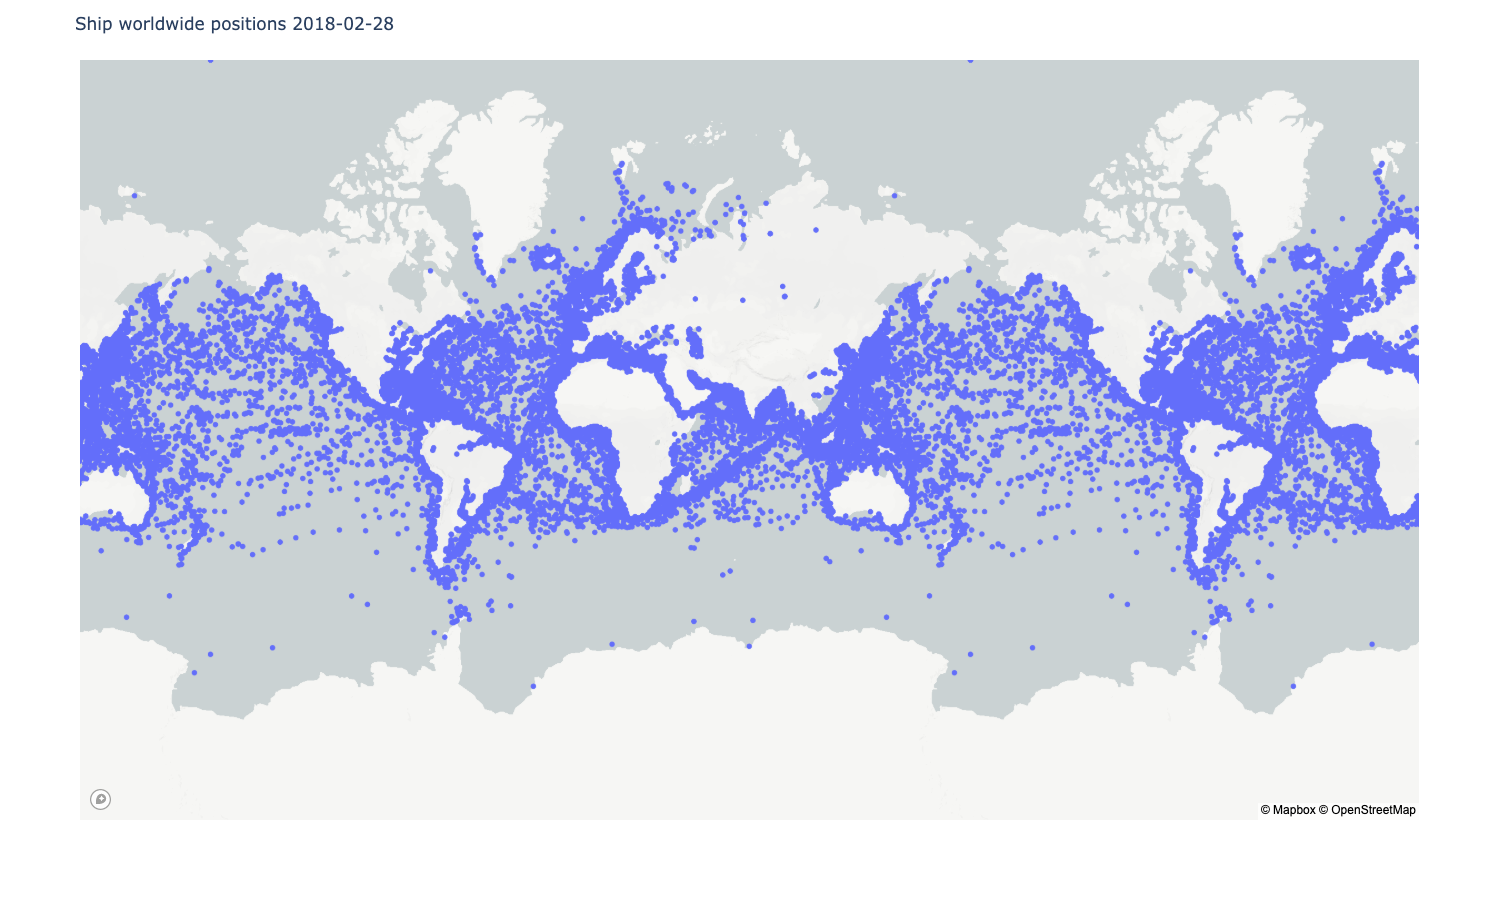

In [14]:
# Show positions of all the vessels in a map 
fig = px.scatter_mapbox(dfPos, lat="lat", lon="lon") #,center=go.layout.mapbox.Center(lat=60,lon=5), zoom=4)
fig.update_layout(
    title='Ship worldwide positions 2018-02-28',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        bearing=0,
        center=dict(lat=50,lon=5),
        pitch=0,
        zoom=1,
        style='light'
    ),
)
fig.show()

In [26]:
import sys
sys.path

['/Users/steinoveerikstad/dev/ais',
 '/opt/anaconda3/lib/python37.zip',
 '/opt/anaconda3/lib/python3.7',
 '/opt/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/opt/anaconda3/lib/python3.7/site-packages',
 '/opt/anaconda3/lib/python3.7/site-packages/aeosa',
 '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/Users/steinoveerikstad/.ipython']

In [27]:
import pickle

# Bruk innebygd DB i python, sqlite3
import sqlite3 as sl

In [28]:
fnamePickle = 'ais_pickle_file'
f = open(fnamePickle,'wb')
pickle.dump(fleet,f)
f.close()


In [30]:
dfShipType = pd.read_csv('../data/AIS/ais_shiptype.csv', sep=';') # Read the file with the position data
dfShipType.head()

Type Code                                   Description
0         20  Wing in ground (WIG), all ships of this type
1         21    Wing in ground (WIG), Hazardous category A
2         22    Wing in ground (WIG), Hazardous category B
3         23    Wing in ground (WIG), Hazardous category C
4         24    Wing in ground (WIG), Hazardous category D

In [22]:
filename = '../data/AIS/ANSData_RawData 01 Jan 2019 ML41438.dat'
f = open(filename, 'rb')
msgs = []
for i in range(100):
    msgs.append(f.readline())

In [18]:
from pyais import FileReaderStream

#filename = "sample.ais"
i=0
pyaisMsgs = []

for msg in FileReaderStream(filename):
    pyaisMsgs.append(msg)
    decoded_message = msg.decode()
    ais_content = decoded_message.content
    print(ais_content)
    i += 1
    if i>10:
        break

In [23]:
msgs[:20]    

[b'\\s:ASM//Port=243//MMSI=,c:1546300800*78\\!BSVDM,1,1,,A,4kP=nBQv;?ossP4liPR6<1O02000,0*48\r\n',
 b'\\s:ASM//Port=243//MMSI=,c:1546300800*78\\!BSVDM,1,1,,A,43m9lL1v;?oss08fV6QIL91006sd,0*13\r\n',
 b'\\s:ASM//Port=243//MMSI=,c:1546300800*78\\!BSVDM,1,1,,A,43o4<N1v;?oss0Mvv>U<9QA00L09,0*7B\r\n',
 b'\\s:ASM//Port=69//MMSI=2573105,c:1546300800*75\\!BSVDM,1,1,,A,402M3<Av;?oss0h93PR7>T700D15,0*6D\r\n',
 b'\\s:ASM//Port=832//MMSI=2573238,c:1546300800*4E\\!BSVDM,1,1,,A,402M3eQv;?oss0GnVtRQ`;w02400,0*7C\r\n',
 b'\\s:ASM//Port=38//MMSI=2573465,c:1546300800*72\\!BSVDM,1,1,,A,402M4VAv<@P0015uRPW>H4700H0:,0*2E\r\n',
 b'\\s:ASM//Port=24//MMSI=2573575,c:1546300800*7F\\!BSVDM,1,1,,A,402M51iv<@P001noK0``6@700L0b,0*67\r\n',
 b'\\s:ASM//Port=838//MMSI=2573938,c:1546300800*4F\\!BSVDM,1,1,,A,402M6LQv;?oss1<@C@derkO02H0:,0*2B\r\n',
 b'\\s:ASM//Port=243//MMSI=,c:1546300800*78\\!BSVDM,1,1,,A,402MN7iv;?oss0;dM2QbaFg02L0>,0*6A\r\n',
 b'\\s:ASM//Port=243//MMSI=,c:1546300800*78\\!BSVDM,1,1,,A,402MN7iv;?oss04m8r

In [20]:
len(pyaisMsgs)

0

In [21]:
from pyais import TCPStream

NMEAMessage(msgs[0])

NameError: name 'NMEAMessage' is not defined

In [24]:
import os

In [32]:
os.getcwd()

'/Volumes/HD SOE SG'

In [28]:
os.chdir('/Users/steinoveerikstad/dev')

In [31]:
os.chdir('/Volumes/HD SOE SG')

In [33]:
os.listdir('.')

['.DS_Store', '.fseventsd', '.Spotlight-V100', '.Trashes', 'aisdata.db']

In [3]:
import sqlite3

In [4]:
database = '/Volumes/HD SOE SG/aisdata.db'
con = sqlite3.connect(database)
cur = con.cursor()


In [5]:
cur.execute('SELECT name from sqlite_master where type= "table"')

print(cur.fetchall())

[('messagetype1',), ('messagetype2',), ('messagetype3',), ('messagetype5',), ('shipregistry',)]


In [40]:
#cur.execute('SELECT * FROM messagetype1')

In [ ]:
#rows = cur.fetchall()

In [6]:
cur.execute('SELECT COUNT(*) FROM messagetype1')

In [7]:
rowcount = cur.fetchone()[0]
print (rowcount)

4546926265


In [11]:
cur.execute('SELECT * FROM messagetype1 LIMIT 10')

In [12]:
data = cur.fetchall()

In [13]:
for row in data:
    print(row)

(331428000, 1517270400, 64.222705, -55.592555, 351, 2.799999952316284, 0, 351.70001220703125, 0.0)
(257333420, 1517270400, 71.47894166666667, 31.76758, 306, 1.600000023841858, 0, 24.299999237060547, 720.0032348632812)
(308243000, 1517270400, 71.67199, 18.343431666666667, 219, 5.900000095367432, 0, 218.6999969482422, -2.856978416442871)
(319087000, 1517270400, -38.04874, 149.24122666666668, 511, 11.0, 0, 253.60000610351562, -731.386474609375)
(477062000, 1517270400, -35.25166, 160.18572666666665, 263, 8.399999618530273, 0, 264.6000061035156, 0.0)
(229934000, 1517270400, 40.5215, -24.357483333333334, 286, 18.299999237060547, 0, 284.5, 0.0)
(366926920, 1517270400, 40.66719666666667, -74.01696333333334, 174, 0.0, 0, 206.0, 0.0)
(259239000, 1517270400, 55.47222166666667, 10.54, 511, 102.30000305175781, 15, 360.0, -731.386474609375)
(258310000, 1517270400, 60.82333333333333, 5.046666666666667, 511, 102.30000305175781, 15, 360.0, -731.386474609375)
(258033000, 1517270400, -6.861111666666667, 

In [18]:
t = 1517270405
strPattern = "%Y-%m-%d %H:%M:%S"
dt = datetime.datetime.utcfromtimestamp(t).strftime("%Y-%m-%d %H:%M:%S")
dt

'2018-01-30 00:00:05'

In [19]:
dtObj = datetime.datetime.strptime(dt, strPattern)
dtObj

datetime.datetime(2018, 1, 30, 0, 0, 5)

In [22]:
#tzinfo = datetime.timezone.utc
utc_time = dt.replace(tzinfo=datetime.timezone.utc)
ts = utc_time.timestamp()
ts

TypeError: replace() takes no keyword arguments

In [25]:
from datetime import timezone
import datetime
  
# Getting the current date
# and time
#dt = datetime.datetime.now(timezone.utc)
dt = dtObj  
utc_time = dt.replace(tzinfo=timezone.utc)
utc_timestamp = utc_time.timestamp()
  
print(utc_timestamp)

1517270405.0


In [24]:
datetime.datetime.now(timezone.utc)

datetime.datetime(2021, 9, 9, 11, 53, 13, 671865, tzinfo=datetime.timezone.utc)

In [20]:
start = timeit.timeit()
cur.execute('SELECT * FROM messagetype1 WHERE unixtime BETWEEN 1517270400 AND 1517356800')
end = timeit.timeit()
print(end-start)

0.002496500999768614


In [21]:
data = cur.fetchall()
len(data)

4934312

In [22]:
start = timeit.timeit()
df = pd.read_sql_query("SELECT * FROM messagetype1 WHERE unixtime BETWEEN 1517270400 AND 1517356800", con)
end = timeit.timeit()
print(end-start)

-1.3116999980411492e-05


In [23]:
df.head()

mmsi    unixtime   latitude   longitude  heading   sog  nav_status  \
0  331428000  1517270400  64.222705  -55.592555      351   2.8           0   
1  257333420  1517270400  71.478942   31.767580      306   1.6           0   
2  308243000  1517270400  71.671990   18.343432      219   5.9           0   
3  319087000  1517270400 -38.048740  149.241227      511  11.0           0   
4  477062000  1517270400 -35.251660  160.185727      263   8.4           0   

          cog         rot  
0  351.700012    0.000000  
1   24.299999  720.003235  
2  218.699997   -2.856978  
3  253.600006 -731.386475  
4  264.600006    0.000000

In [ ]:
start = timeit.timeit()
dfShips = pd.read_sql_query("SELECT * FROM messagetype5", con)
end = timeit.timeit()
print(end-start)

In [ ]:
start = timeit.timeit()
dfShips = pd.read_sql_query("SELECT * FROM messagetype5 WHERE unixtime BETWEEN 1517270400 AND 1517356800", con)
end = timeit.timeit()
print(end-start)

In [ ]:
def extractAISData(fromDate, toDate):
    
    # Connect to the database, and get cursor
    database = '/Volumes/HD SOE SG/aisdata.db'
    con = sqlite3.connect(database)
    cur = con.cursor()
    
    # Read relevant data from database
    df = pd.read_sql_query("SELECT * FROM messagetype1 WHERE unixtime BETWEEN 1517270400 AND 1517356800", con)
    dfShips = pd.read_sql_query("SELECT * FROM messagetype5 WHERE unixtime BETWEEN 1517270400 AND 1517356800", con)

# Find the unique signal transmitters in the position dataset
unique_mmsi = dfPos.mmsi.unique()
len(unique_mmsi) # The number of unique vessels transmitting positions